## Imports

In [1]:
from keras import layers, callbacks, utils, metrics, Sequential, optimizers, initializers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score

## Constants

In [2]:
BATCH_SIZE = 64
IMG_HEIGHT = 256
IMG_WIDTH = 256
LEARNING_RATE = 1e-5

DATASET_PATH = "../../cats_and_dogs"
DATASET_TRAIN_PATH = f"{DATASET_PATH}/train"
DATASET_VAL_PATH = f"{DATASET_PATH}/validation"

NUM_CLASSES = 2

SEED = 7654321

VAL_TEST_RATIO = 0.5

MAX_EPOCHS = 100

WEIGHTS_FILE_EXT = "weights.h5"
HYPERPARAMS_FILE_EXT = "hyperparams.json"

# callback para parar o treino caso não se verifiquem melhorias na loss
EARLY_STOPPING = callbacks.EarlyStopping(monitor="val_loss", patience=5)

INITIALIZER = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=SEED)
GLOROT_UNIFORM_INITIALIZER = initializers.GlorotUniform(seed=SEED)

DEFAULT_LOSS = "binary_crossentropy"
DEFAULT_OPTIMIZER = optimizers.Adam(learning_rate=LEARNING_RATE)
DEFAULT_METRICS = ["accuracy", metrics.F1Score]

2025-03-29 14:55:19.931397: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-03-29 14:55:19.931422: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-03-29 14:55:19.931425: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
I0000 00:00:1743260119.931436  848519 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1743260119.931456  848519 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Dataset load

In [3]:
train_ds = utils.image_dataset_from_directory(
    DATASET_TRAIN_PATH,
    labels="inferred",
    label_mode="binary",
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    verbose=False,
)

val_ds, test_ds = utils.image_dataset_from_directory(
    DATASET_VAL_PATH,
    labels="inferred",
    label_mode="binary",
    validation_split=VAL_TEST_RATIO,
    subset="both",
    seed=SEED,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    verbose=False,
)
labels = train_ds.class_names

# load the datasets into memory - once loaded, the order of the batches will no longer change
train_ds = train_ds.cache()
val_ds = val_ds.cache()
test_ds = test_ds.cache()

Using 500 files for training.
Using 500 files for validation.


# Model with three levels

In [4]:
three_feature_levels_model = Sequential(
    [
        layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        # Low level features
        layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.MaxPooling2D(pool_size=(4, 4)),

        # Mid level features
        layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.MaxPooling2D(),

        # High level features
        layers.Conv2D(96, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.Conv2D(96, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.Conv2D(96, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.MaxPooling2D(),

        # Hidden layer
        layers.Dense(128, activation="relu", kernel_initializer=INITIALIZER),
        layers.Dense(160, activation="relu", kernel_initializer=INITIALIZER),

        # Classifier
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid", kernel_initializer=INITIALIZER)
    ], name="three_feature_levels_model"
)

three_feature_levels_model.compile(
    loss=DEFAULT_LOSS,
    optimizer=DEFAULT_OPTIMIZER,
    metrics=DEFAULT_METRICS
)

## Model summary

In [5]:
three_feature_levels_model.summary()

Model: "three_feature_levels_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16, 16, 128)    │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16, 16, 160)    │        20,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        40,961 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 518,081 (1.98 MB)

 Trainable params: 518,081 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

## Model fit

In [6]:
BEST_THREE_LEVELS_MODEL = f"../../models/{three_feature_levels_model.name}.{WEIGHTS_FILE_EXT}"

three_feature_levels_model_checkpoint = callbacks.ModelCheckpoint(
    filepath=BEST_THREE_LEVELS_MODEL,
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
)

three_feature_levels_model_history = three_feature_levels_model.fit(
    train_ds,
    epochs=MAX_EPOCHS,
    validation_data=val_ds,
    callbacks=[three_feature_levels_model_checkpoint, EARLY_STOPPING],
)

Epoch 1/100


2025-03-29 14:55:21.205205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.4973 - f1_score: 0.6532 - loss: 0.7012 - val_accuracy: 0.5440 - val_f1_score: 0.6649 - val_loss: 0.6887
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5528 - f1_score: 0.6532 - loss: 0.6876 - val_accuracy: 0.5420 - val_f1_score: 0.6649 - val_loss: 0.6859
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5556 - f1_score: 0.6532 - loss: 0.6846 - val_accuracy: 0.5640 - val_f1_score: 0.6649 - val_loss: 0.6830
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5689 - f1_score: 0.6532 - loss: 0.6812 - val_accuracy: 0.5780 - val_f1_score: 0.6649 - val_loss: 0.6790
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.5996 - f1_score: 0.6532 - loss: 0.6765 - val_accuracy: 0.5860 - val_f1_score: 0.6649 - val_loss: 0.6730
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.6103 - f1_score: 0.6532 - loss: 0.6706 - val_accuracy: 0.5920 - val_f1_score: 0.6649 - val_loss: 0.664

## Quality of the model

2025-03-29 15:19:10.662496: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
Falhou em 162 amostras num total de 500 imagens de flores
Test Dataset Metrics:
Taxa de acertos: 67.60 %
Precisão: 65.3710 %
Cobertura: 74.2972 %
F1 Score: 69.5489 %


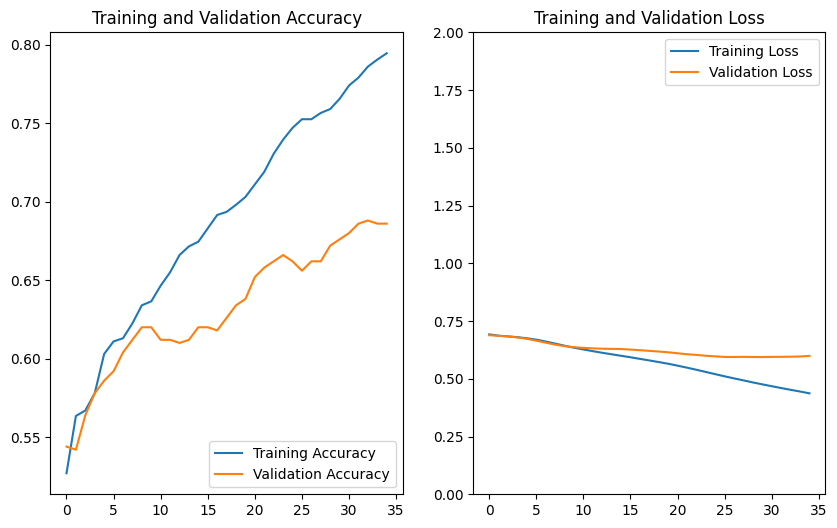

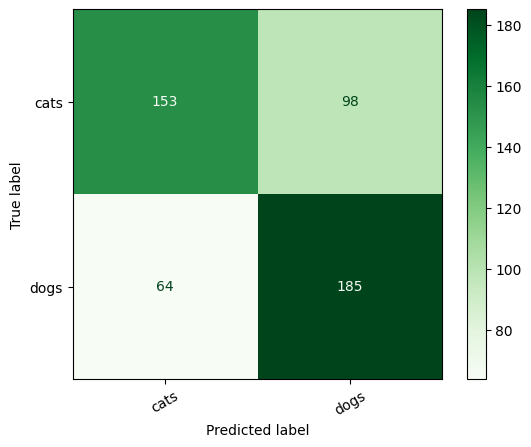

In [7]:
# carregar o melhor modelo encontrado durante o treino
three_feature_levels_model.load_weights(BEST_THREE_LEVELS_MODEL)

# obter as predições e ground thruth num formato mais fácil de tratar
# (vetores com os ids das classes)

y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

# Make predictions
output_pred = three_feature_levels_model.predict(val_ds)
y_pred = (output_pred > 0.5).astype(int).flatten()  # Convert sigmoid output to 0 or 1

# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

n_misses = np.count_nonzero(y_pred != y_true.flatten())
n_preds = y_pred.shape[0]
accuracy = (n_preds - n_misses) / n_preds

print(
    "Falhou em {:d} amostras num total de {:d} imagens de flores".format(
        n_misses, n_preds
    )
)

# Calculate precision, recall, and F1 score
test_precision = precision_score(y_true, y_pred)
test_recall = recall_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred)

print(f"Test Dataset Metrics:")
print("Taxa de acertos: {:.2f} %".format(accuracy * 100))
print(f"Precisão: {test_precision * 100:.4f} %")
print(f"Cobertura: {test_recall * 100:.4f} %")
print(f"F1 Score: {test_f1 * 100:.4f} %")


# gerar gráficos e matriz de confusão
cm = confusion_matrix(y_true, y_pred)

acc = three_feature_levels_model_history.history["accuracy"]
val_acc = three_feature_levels_model_history.history["val_accuracy"]
loss = three_feature_levels_model_history.history["loss"]
val_loss = three_feature_levels_model_history.history["val_loss"]
epochs_range = range(len(acc))

# evolucao da loss e acertos
plt.figure(2, figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylim(0, 2)
plt.title("Training and Validation Loss")

# matriz de confusao
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Greens", xticks_rotation=30)
plt.show()